## Exercise 5.4 SVM (4 points)

In [155]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_circles

### Generating the data

In [156]:
X, y = make_circles(n_samples=500, noise=0.05, random_state=42)
df = pd.DataFrame(dict(x1=X[:, 0], x2=X[:, 1], y=y))

#map classes to -1 and 1 for simplification
df["y"] = df["y"].apply(lambda x: x if x else -1)

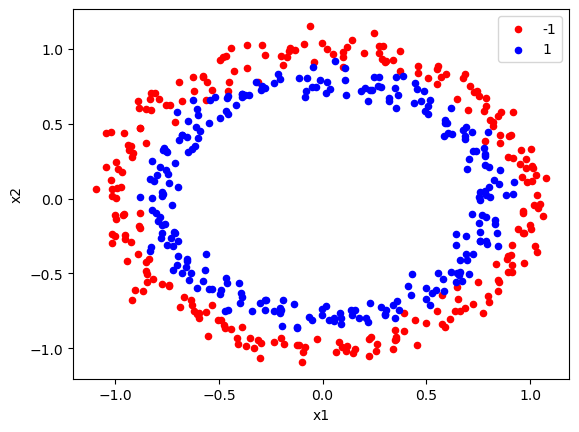

In [157]:
colors = {-1: "red", 1: "blue"}
fig, ax = plt.subplots()
grouped = df.groupby("y")
for key, group in grouped:
    group.plot(ax=ax, kind="scatter", x="x1", y="x2", label=key, color=colors[key])
plt.show()

In [158]:
from sklearn.model_selection import train_test_split

X = df[["x1", "x2"]]
y = df["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.7, random_state=42
)

### SVM (4 points)

Support Vector Machines (SVMs) are a powerful and versatile class of supervised machine learning algorithms used for classification and regression tasks. At their core, SVMs aim to find a hyperplane that best separates different classes of data. The beauty of SVMs lies in their ability to handle both linear and non-linear data using kernel functions.

In a two-dimensional space, an SVM finds a line (and in higher dimensions, a hyperplane) that best separates the classes. This line is determined by the support vectors, which are the data points nearest to the hyperplane.
The equation of the hyperplane can be represented as:
The equation of the hyperplane can be represented as:
$$ w \cdot x + b = 0 $$
where \( w \) is the weight vector and \( b \) is the bias.


The regularized hinge loss, which is used for training Support Vector Machines with L2 regularization, is given by:
   $$ L(w,b) = \frac{\lambda}{2} ||w||^2 + \sum_{i} \max(0, 1 - y_i(w \cdot x_i + b)) $$

where:
- \( \lambda \) is the regularization parameter.
- \( w \) is the weight vector.
- \( b \) is the bias term.
- \( x_i \) is the feature vector of the \( i^{th} \) data point.
- \( y_i \) is the actual label of the \( i^{th} \) data point, with \( y_i \in \{ -1, 1 \} \).


For non-linearly separable data, SVMs use the kernel trick. A kernel function transforms the data into a higher-dimensional space where it becomes linearly separable. Common kernels include the linear, polynomial, and radial basis function (RBF) kernels.

### The Polynomial Kernel
The polynomial kernel function, commonly used with SVMs, is defined as:

$$ K(x_1, x_2) = (x_1^T x_2 + c)^d $$

where:
- \( x_1 \) and \( x_2 \) are two input vectors.
- \( x_1^T x_2 \) represents the dot product of \( x_1 \) and \( x_2 \).
- \( c \) is a constant term that allows for tuning of the kernel's behavior.
- \( d \) is the degree of the polynomial.

where **c** is a constant and **x1** and **x2**  are vectors in the original space.

The parameter **c** can be used to control the trade-off between the fit of the training data and the size of the margin. A large **c** value will give a low training error but may result in overfitting. A small **c** value will give a high training error but may result in underfitting. The degree **d** of the polynomial can be used to control the complexity of the model. A high degree d will result in a more complex model that may overfit the data, while a low degree **d** will result in a simpler model that may underfit the data.

When a dataset is given containing features x1 and x2, the equation can be transformed as:
$$
\begin{bmatrix}
x_1 \\
x_2 
\end{bmatrix}
\cdot
\begin{bmatrix}
x_1 & x_2
\end{bmatrix}
=
\begin{bmatrix}
x_1^2 & x_1 x_2 \\
x_1 x_2 & x_2^2
\end{bmatrix}
$$

The important terms we need to note are **x1**, **x2**, **x1^2**, **x2^2** , and **x1 * x2**. When finding these new terms, the non-linear dataset is converted to another dimension that has features **x1^2**, **x2^2** , and **x1 * x2**.


**Note**: When employing the polynomial kernel, it is crucial to ensure that you apply this kernel transformation to both the training data during the 'fit' function and the test data during the 'predict' function. 

### Implementing SVM 

In [159]:
import numpy as np

class SVM:
    def __init__(self, 
                C=1.0, 
                learning_rate=0.001, 
                lambda_param=1e-2, 
                kernel=None):
        # C = error term
        self.C = C
        self.lambda_param = lambda_param
        self.lr = learning_rate
        self.kernel = kernel

    def polynomial_transform(self, X):
        # implement the polynomial transformation based on the equation given above
        # This computes the polynomial transform on every i-th vector in X
        if self.kernel == 'poly': # Use polynomial transform of order 2
            d = 2
        else:
            return X # If linear, then return same features (150, 2)

        # Creates an upper triangular mask. For example, for len(x) = 2
        # [[1, 1]
        #  [0, 1]]
        # This will be used to get the polynomial features out of x^T * x
        # Since x^T * x is symmetric and we don't want to repeat values,
        # we only take the upper triangular ones (we could also take the
        # lower triangular ones)
        mask = np.tri(X.shape[1], k=0, dtype=bool).T
        
        # Adds a new axis converting (150, 2) to (150, 2, 1)
        X = X[:, :, np.newaxis]

        X_T = X

        # (150, 2, 1) to (150, 1, 2)
        X_T = X_T.transpose(0, 2, 1)
        
        # Compute outer product for each row
        X_transformed = np.matmul(X, X_T)

        # Only get the upper triangular part of each inner matrix
        X_masked = X_transformed[:, mask]

        # Sum C to every element and then element-wise power to d
        # In the end getting (150, 3) from an original (150, 2)
        return np.power(X_masked + self.C, d)

    def update(self, dw, db):
        #update w and b based on the gradients
        self.w -= self.lr * dw
        self.b -= self.lr * db

    def calculate_gradients(self, x, y, loss):
        # calculate gradients
        # If the second term of the max function for an i-th row is <= 0, then 
        # the whole term will be 0, therefore it is not taken into account 
        # for the gradient. It should however be taken into account for the 
        # i-th rows that are greater than 0
        mask = 1 - (y * self.forward(x)) > 0
        y = y[mask]
        x = x[mask, :]
        assert y.shape[0] == x.shape[0] # They should be the same size in rows

        dw = self.lambda_param * self.w
        db = 0

        if x.size != 0 and y.size != 0: 
            dw -= np.dot(y, x) # Add the last term after taking derivative
            db -= np.sum(y)

        return dw, db

    def forward(self, X):
        return np.dot(self.w, X.T) + self.b

    def hinge_loss(self, output, y):
        reg = 0.5 * np.linalg.norm(self.w, 2) ** 2
        return reg + np.sum(np.maximum(0, 1 - y * output))

    def init_weights(self, X):
        # Initialize the wights and biases to 0
        if self.kernel == 'poly':
            # If X has 2 features, then the kernel trick would give us 3 values,
            # so we need 3 weights, one for each x1^2, x2^2 and x1 * x2
            n_features = X.shape[1]
            n = (n_features * (n_features + 1)) // 2
        else:
            n = X.shape[1]

        self.w = np.zeros(n)
        self.b = 0

    def fit(self, X, Y, epochs=1000, verbose_interval: int = -1):
        #Implement gradient descent
        if type(X) != np.ndarray:
            X = X.to_numpy()
        
        if type(Y) != np.ndarray:
            Y = Y.to_numpy()

        self.init_weights(X)
        X_transformed = self.polynomial_transform(X)

        for _ in range(epochs):
            outputs = self.forward(X_transformed)
            loss = self.hinge_loss(outputs, Y)
            dw, db = self.calculate_gradients(X_transformed, Y, loss)
            self.update(dw, db)

            # This is just for printing nicely
            if ((_ + 1) % verbose_interval == 0 or _ == epochs - 1) and verbose_interval != -1:
                print(f"\tLoss at {_ + 1} epoch = {loss}")

    def predict_score(self, x):
        # In principle, it should be the same as the forward method, but in 
        # case we would like to change up the prediction score for something
        # else
        return self.forward(x)
    
    def predict(self, X):
        if type(X) != np.ndarray:
            X = X.to_numpy()
    
        X_transformed = self.polynomial_transform(X)
        outputs = self.forward(X_transformed)
        Y = np.sign(outputs)
        return Y

### SVM class with a linear kernel

Create an SVM with linear kernel and calulate the accuracy score

In [160]:
from sklearn.metrics import accuracy_score

linear_svm = SVM(C = 0, kernel='linear', learning_rate=0.001)

print("Fitting Linear SVM: ")
linear_svm.fit(X_train, y_train, epochs=1000, verbose_interval=100)

y_train_predicted = linear_svm.predict(X_train)
y_test_predicted = linear_svm.predict(X_test)

print("")
print(f"\tTraining Accuracy = {accuracy_score(y_train, y_train_predicted)}")
print(f"\tTest Accuracy = {accuracy_score(y_test, y_test_predicted)}")

Fitting Linear SVM: 
	Loss at 100 epoch = 136.04543476124394
	Loss at 200 epoch = 136.17661580068636
	Loss at 300 epoch = 136.19744234568662
	Loss at 400 epoch = 136.65545257303785
	Loss at 500 epoch = 136.39701481094798
	Loss at 600 epoch = 136.1910611664554
	Loss at 700 epoch = 136.1455331984433
	Loss at 800 epoch = 136.4054696846928
	Loss at 900 epoch = 136.21459174359578
	Loss at 1000 epoch = 136.32357540585704

	Training Accuracy = 0.5466666666666666
	Test Accuracy = 0.48


/home/Camilo/Documentos/Aplicaciones/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/home/Camilo/Documentos/Aplicaciones/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/home/Camilo/Documentos/Aplicaciones/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/home/Camilo/Documentos/Aplicaciones/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/home/Camilo/Documentos/Aplicaci

### SVM class with a polynomial kernel

Create an SVM with polynomial kernel and calulate the accuracy score

In [161]:
poly_svm = SVM(C = 1, kernel='poly')

print("Fitting Polynomial SVM: ")
poly_svm.fit(X_train, y_train, verbose_interval=100)

y_train_predicted = poly_svm.predict(X_train)
y_test_predicted = poly_svm.predict(X_test)

print("")
print(f"\tTraining Accuracy = {accuracy_score(y_train, y_train_predicted)}")
print(f"\tTest Accuracy = {accuracy_score(y_test, y_test_predicted)}")

Fitting Polynomial SVM: 
	Loss at 100 epoch = 100.64119166437104
	Loss at 200 epoch = 79.78709244431347
	Loss at 300 epoch = 60.79175617879202
	Loss at 400 epoch = 50.26355210977903
	Loss at 500 epoch = 44.27707236351203
	Loss at 600 epoch = 39.37615073006915
	Loss at 700 epoch = 35.65392777925237
	Loss at 800 epoch = 32.76030107700862
	Loss at 900 epoch = 31.071415535326572
	Loss at 1000 epoch = 29.936376503048084

	Training Accuracy = 0.9533333333333334
	Test Accuracy = 0.9514285714285714


/home/Camilo/Documentos/Aplicaciones/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/home/Camilo/Documentos/Aplicaciones/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/home/Camilo/Documentos/Aplicaciones/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/home/Camilo/Documentos/Aplicaciones/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/home/Camilo/Documentos/Aplicaci

#### Plotting the transformed input 

In [162]:
import plotly.express as px

def plot_transformed(df):
    df["x1^2"] = df["x1"] ** 2
    df["x2^2"] = df["x2"] ** 2
    df["x1*x2"] = df["x1"] * df["x2"]

    fig = px.scatter_3d(df, x="x1^2", y="x2^2", z="x1*x2", color="y")
    fig.show()

plot_transformed(df)

#### Using SVM on real dataset (1 point)

Utilize the Support Vector Machine (SVM) with a polynomial kernel to tackle the task of classifying Flower Species. Given that this problem involves multiple classes and the SVMyou implemented is a binary classifier, employ the [one-vs-all](https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/one-vs-all#:~:text=all%20provides%20a%20way%20to,classifier%20for%20each%20possible%20outcome.) classification strategy. This approach will enable you to train a separate classifier for each possible outcome, effectively addressing the multi-class nature of the problem.

In [163]:
df = pd.read_csv("./IRIS.csv")
df.sample(3)

,sepal_length,sepal_width,petal_length,petal_width,species
111,6.4,2.7,5.3,1.9,Iris-virginica
40,5.0,3.5,1.3,0.3,Iris-setosa
52,6.9,3.1,4.9,1.5,Iris-versicolor


In [169]:
np.unique(df.species.to_numpy())

X = df[["sepal_length", "sepal_width", "petal_length", "petal_width"]]
y = df["species"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.7, random_state=42
)

# Assign a numerical label for each possible species
label_assignment = {}
unique_species = np.unique(df["species"].to_numpy())
for label, species in enumerate(unique_species):
    label_assignment[label] = species

print(label_assignment)

{0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}


In [170]:
# Convert everything to numpy arrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Change y vectors to contain the numerical labels we came up with previously
for label,species in label_assignment.items():
    y_train[y_train == species] = label 
    y_test[y_test == species] = label

In [ ]:
# Easy implementation of a One vs Rest MultiClass SVM
class MultiClassSVM:

    def __init__(self, n_classes, labels):
        self.n_classes = n_classes
        self.svms = [SVM() for _ in range(n_classes)]  # List of binary SVMs for each class
        self.labels = labels

    def fit(self, X, Y, epochs=1000):
        for i in range(self.n_classes):
            # Make a copy of original training data
            X_or = X.copy()
            Y_or = Y.copy()

            # Turn the labels we want for this SVM to 1
            X_or[Y == self.labels[i]] = 1
            Y_or[Y == self.labels[i]] = 1

            # Turn the rest to 0
            X_or[Y != self.labels[i]] = 0
            Y_or[Y != self.labels[i]] = 0

            self.svms[i].fit(X, )

    def predict(self, X):
        # Predict the class for each sample in X
        predictions = np.zeros(X.shape[0], dtype=int)
        for i in range(X.shape[0]):
            max_score = float('-inf')
            predicted_class = None

            for j in range(self.n_classes):
                score = self.svms[j].predict_score(X[i])
                if score > max_score:
                    max_score = score
                    predicted_class = j

            predictions[i] = predicted_class
        return predictions

multi_svm = MultiClassSVM(n_classes=3)